In [2]:
import os
from ModularCirc.Models.KorakianitisMixedModel import KorakianitisMixedModel, KorakianitisMixedModel_parameters, TEMPLATE_TIME_SETUP_DICT
from ModularCirc import BatchRunner
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import pickle
from cvdnet_pipeline.utils import helper_functions, plot_utils

In [3]:
n_samples = 100
n_params = 9
data_type = "synthetic"
output_path = "../output_synthetic"

all_output_keys = [
        "edp",
        "dia",
        "epad",
        "eivc",
        "sys",
        "esp",
        "a_epad",
        "P_max",
        "EF",
        "Ees/Ea",
        "iT",
        "PC1",
        "PC2",
        "PC3"
    ]

calibration_path = "14_output_keys/kf_calibration_results/14_output_keys/calibration_20250924_152801/kf_estimated_means"

# Emulators
emulators= pd.read_pickle(f"{output_path}/output_{n_samples}_{n_params}_params/emulators/linear_models_and_r2_scores_{n_samples}.pkl")

# True imputs
true_inputs = pd.read_csv(f"{output_path}/pure_input_{n_samples}_{n_params}_params.csv")

# True outputs
true_output = pd.read_csv(f"{output_path}/output_{n_samples}_{n_params}_params/waveform_resampled_all_pressure_traces_rv_with_pca.csv")

# Calibrated inputs
calibrated_inputs = pd.read_csv(f"{output_path}/output_{n_samples}_{n_params}_params/kf_calibration_results/{calibration_path}.csv")

# Select emulators and data for specified output_keys
emulator_output = emulators.loc[all_output_keys]
observation_data = true_output.loc[:, all_output_keys] 

# Model error (RMSE from cross-validation)
model_error = np.array(emulator_output['RMSE']).reshape(14,1)

# Construct beta matrix and intercepts
beta_matrix = []
intercept = []

for _, row_entry in emulator_output.iterrows():
    model = row_entry['Model']
    beta_matrix.append(model.coef_)
    intercept.append(model.intercept_)

beta_matrix = np.array(beta_matrix)
intercept = np.array(intercept).reshape(len(intercept), 1)

# emulator predictions for true inputs
emulator_predictions_true = np.dot(beta_matrix, true_inputs.T) + intercept
emulator_predictions_true = pd.DataFrame(emulator_predictions_true.T, columns=all_output_keys)


# emulator predictions for calibrated inputs
emulator_predictions_calibrated = np.dot(beta_matrix, calibrated_inputs.T) + intercept 
emulator_predictions_calibrated = pd.DataFrame(emulator_predictions_calibrated.T, columns=all_output_keys)


# Plot results
plt.figure(figsize=(15, 10))
for i, key in enumerate(all_output_keys):
    plt.subplot(4, 4, i+1)
    plt.scatter(observation_data[key], emulator_predictions_true[key], label='True Inputs', alpha=0.5, c='blue')
    plt.scatter(observation_data[key], emulator_predictions_calibrated[key], label='Calibrated Inputs', alpha=0.5, c='orange')
    plt.plot([observation_data[key].min(), observation_data[key].max()], 
             [observation_data[key].min(), observation_data[key].max()], 'r--')
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    plt.title(key)
    plt.legend()
plt.tight_layout()




FileNotFoundError: [Errno 2] No such file or directory: '../output_synthetic/output_100_9_params/kf_calibration_results/14_output_keys/kf_calibration_results/14_output_keys/calibration_20250924_152801/kf_estimated_means.csv'

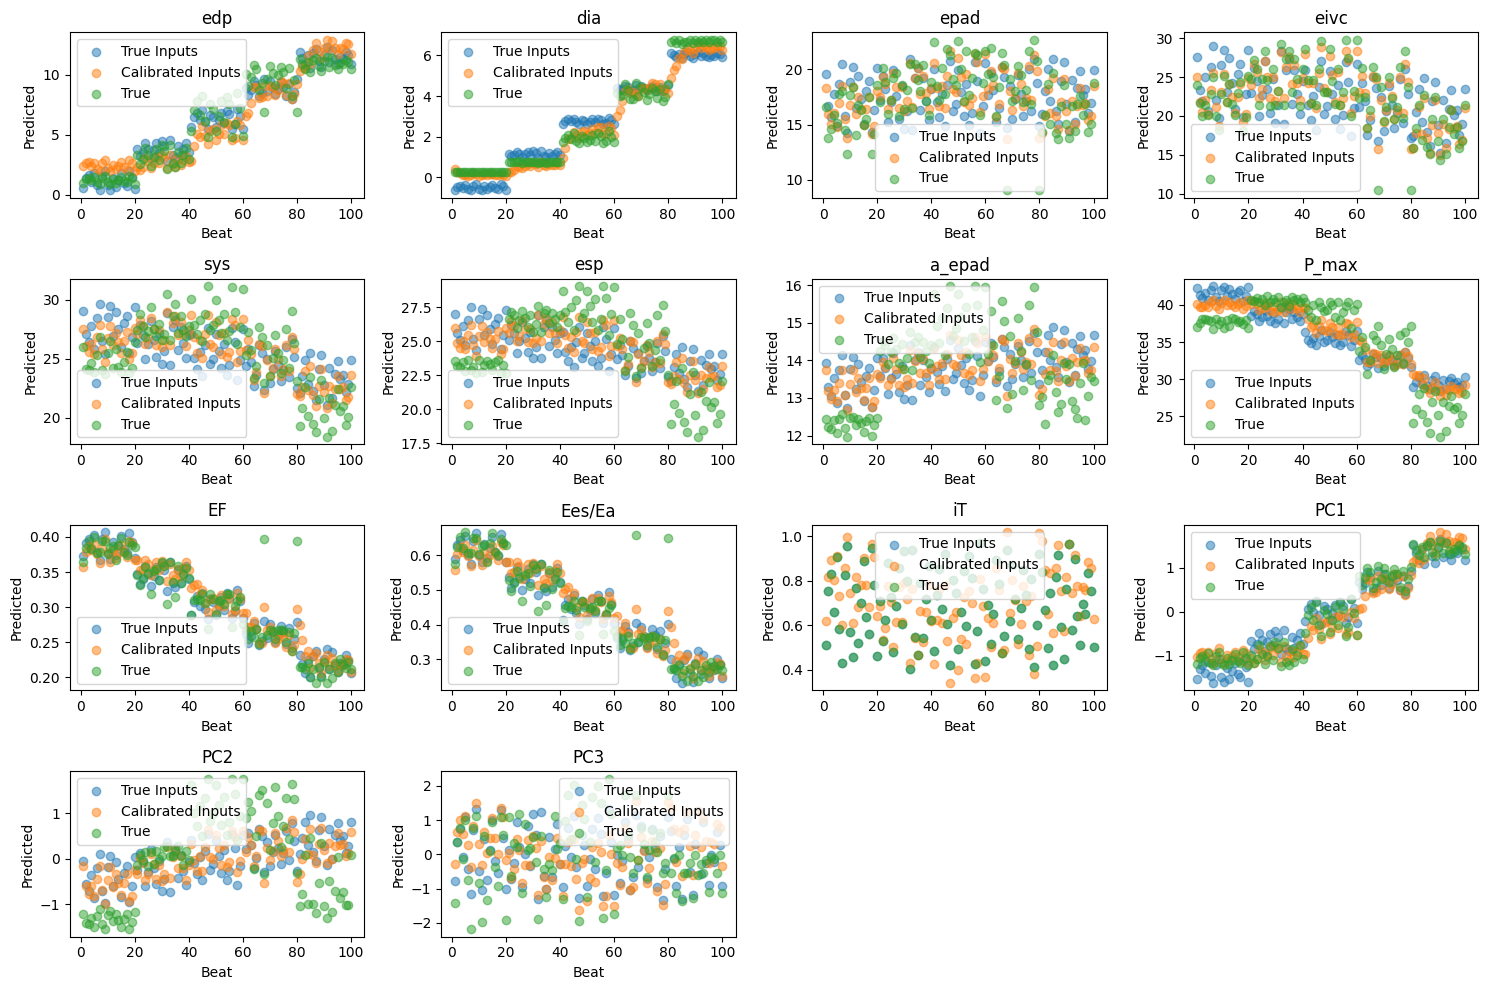

In [ ]:
X = np.arange(1,101)
plt.figure(figsize=(15, 10))
for i, key in enumerate(all_output_keys):
    plt.subplot(4, 4, i+1)
    plt.scatter(X, emulator_predictions_true[key], label='True Inputs', alpha=0.5)
    plt.scatter(X, emulator_predictions_calibrated[key], label='Calibrated Inputs', alpha=0.5)
    plt.scatter(X, observation_data[key], label='True', alpha=0.5)
    plt.xlabel('Beat')
    plt.ylabel('Predicted')
    plt.title(key)
    plt.legend()
plt.tight_layout()

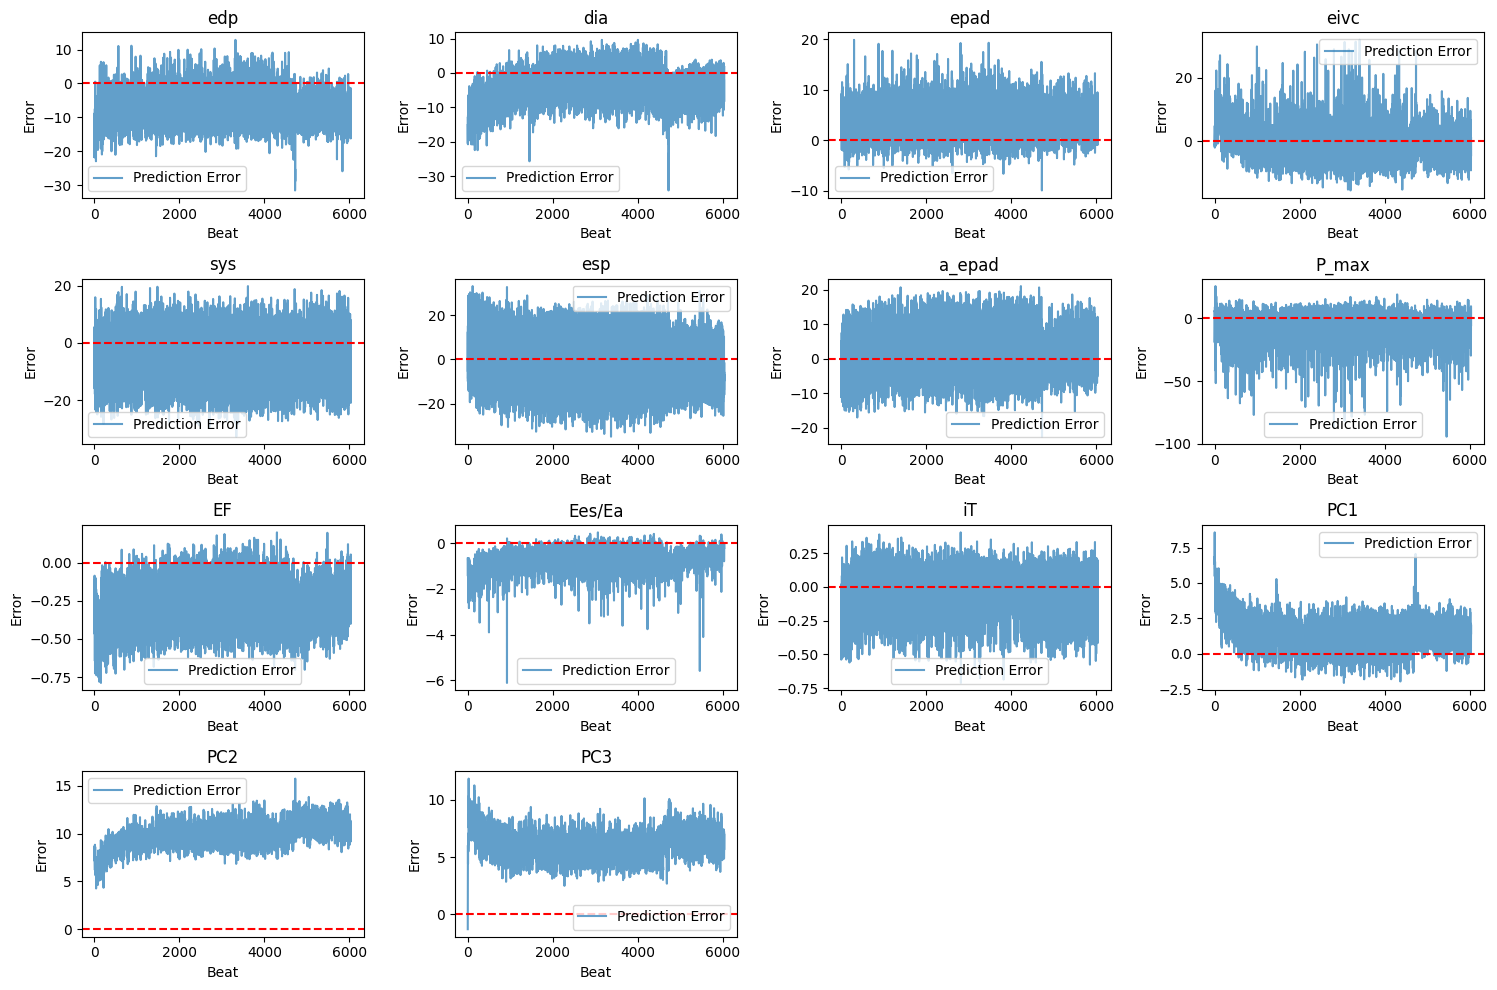

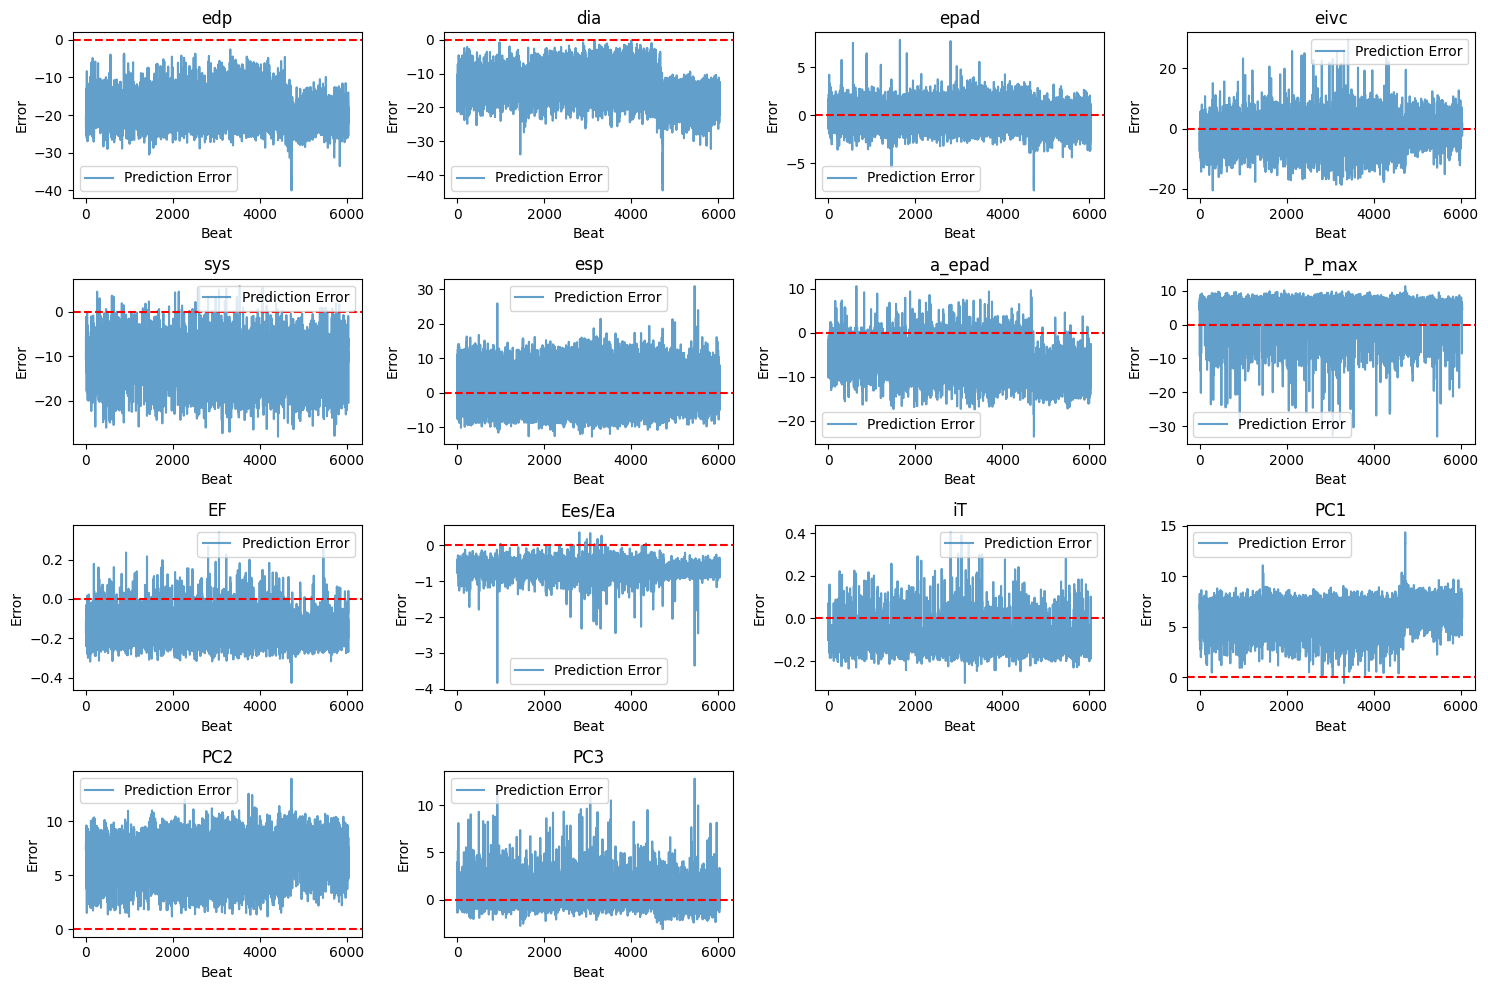

In [3]:
n_samples = 4096
n_params = 9
data_type = "real"
emulator_path = "../output_synthetic"
data_path = "../CohortDataRaw2/output_real/pat_6_night"

all_output_keys = [
        "edp",
        "dia",
        "epad",
        "eivc",
        "sys",
        "esp",
        "a_epad",
        "P_max",
        "EF",
        "Ees/Ea",
        "iT",
        "PC1",
        "PC2",
        "PC3"
    ]

calibration_path_kf = "kf_calibration_results/14_output_keys/kf_calibration_results/14_output_keys/calibration_20251013_115339/kf_estimated_means.csv"
calibration_path_b2b = "bayesian_calibration_results/14_output_keys/calibration_20251013_115339/posterior_mean.csv"

# Emulators
emulators= pd.read_pickle(f"{emulator_path}/output_{n_samples}_{n_params}_params/emulators/linear_models_and_r2_scores_{n_samples}.pkl")


# True output data
true_output = pd.read_csv(f"{data_path}/waveform_resampled_all_pressure_traces_rv_with_pca.csv")

# Calibrated inputs
calibrated_inputs_kf = pd.read_csv(f"{data_path}/{calibration_path_kf}")
calibrated_inputs_b2b = pd.read_csv(f"{data_path}/{calibration_path_b2b}")

# Select emulators and data for specified output_keys
emulator_output = emulators.loc[all_output_keys]
observation_data = true_output.loc[:, all_output_keys] 


# Construct beta matrix and intercepts
beta_matrix = []
intercept = []

for _, row_entry in emulator_output.iterrows():
    model = row_entry['Model']
    beta_matrix.append(model.coef_)
    intercept.append(model.intercept_)

beta_matrix = np.array(beta_matrix)
intercept = np.array(intercept).reshape(len(intercept), 1)


# emulator predictions for calibrated inputs
emulator_predictions_calibrated_kf = np.dot(beta_matrix, calibrated_inputs_kf.T) + intercept 
emulator_predictions_calibrated_kf = pd.DataFrame(emulator_predictions_calibrated_kf.T, columns=all_output_keys)

emulator_predictions_calibrated_b2b = np.dot(beta_matrix, calibrated_inputs_b2b.T) + intercept 
emulator_predictions_calibrated_b2b = pd.DataFrame(emulator_predictions_calibrated_b2b.T, columns=all_output_keys)


# prediction error (between emulator predictions and observed data)
prediction_error_kf = emulator_predictions_calibrated_kf.values - observation_data.values
prediction_error_kf_df = pd.DataFrame(prediction_error_kf, columns=all_output_keys)
prediction_error_b2b = emulator_predictions_calibrated_b2b.values - observation_data.values
prediction_error_b2b_df = pd.DataFrame(prediction_error_b2b, columns=all_output_keys)

# Plot prediction error through time for each output key
plt.figure(figsize=(15, 10))
for i, key in enumerate(all_output_keys):
    plt.subplot(4, 4, i+1)
    plt.plot(prediction_error_kf[:, i], label='Prediction Error', alpha=0.7)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel('Beat')
    plt.ylabel('Error')
    plt.title(f'{key}')
    plt.legend()
plt.tight_layout()

plt.figure(figsize=(15, 10))
for i, key in enumerate(all_output_keys):       
    plt.subplot(4, 4, i+1)
    plt.plot(prediction_error_b2b[:, i], label='Prediction Error', alpha=0.7)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel('Beat')
    plt.ylabel('Error')
    plt.title(f'{key}')
    plt.legend()
plt.tight_layout()



In [6]:
eigen = beta_matrix.T @ beta_matrix
eigenvalues, eigenvectors = np.linalg.eig(eigen)
eigenvectors[:,-1], eigenvalues



(array([-1.85216195e-05,  2.00294830e-04,  9.99999657e-01,  6.12890643e-04,
        -1.34711761e-04, -1.30740006e-05, -4.97656698e-04, -9.07180365e-06,
         5.76625706e-05]),
 array([7.33218268e+04, 6.53694559e+03, 2.23240437e+03, 9.93915317e+01,
        4.56603518e+00, 1.70863010e+00, 2.92868399e-01, 1.43363570e-02,
        4.94352118e-08]))

In [7]:
prediction_error_kf_df

,edp,dia,epad,eivc,sys,esp,a_epad,P_max,EF,Ees/Ea,iT,PC1,PC2,PC3
0,-20.387532,-15.121181,0.349273,-1.345651,-10.572394,-5.090181,-6.231139,5.870430,-0.116278,-0.661162,-0.080771,6.811284,7.832668,-1.284179
1,-21.744252,-20.049141,0.842569,-1.214611,-5.220998,4.376098,-8.193737,6.271697,-0.235459,-0.925301,-0.061633,7.631256,7.766164,0.782596
2,-18.478639,-20.496461,2.293387,-0.863567,-2.968319,12.479327,-3.182005,-19.090075,-0.465486,-1.423807,-0.538660,6.328522,7.800136,4.169127
3,-21.776174,-12.744666,0.089425,-0.982980,-15.883262,-9.920706,-11.084068,2.452738,-0.118177,-0.738753,0.008032,8.571374,8.696377,3.655696
4,-9.486960,-15.468012,7.919912,4.871016,5.595997,15.171403,5.152468,-13.827281,-0.466069,-1.430975,-0.092925,5.474121,7.163365,6.028625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6032,-4.825555,-6.913523,2.230503,-8.884370,-9.902774,-5.639918,0.091516,-12.452655,-0.200304,-0.266098,0.099993,1.081798,9.177880,6.440680
6033,-16.233213,-8.332062,-0.966274,-9.076008,-20.971194,-9.769799,-4.335138,-16.811087,-0.229662,-0.356573,-0.416480,0.217125,10.285466,7.032862
6034,-5.912285,-3.934967,7.041702,1.320985,7.975400,-1.422868,12.182498,9.721935,0.053066,0.021946,0.199382,1.241824,10.301242,6.577203
6035,-7.130293,-8.264324,4.090721,-4.554565,-6.651513,-15.990322,0.687121,-9.381701,-0.052653,-0.136966,0.035272,2.052988,10.864623,5.995532


In [8]:
# emu error
emu_error = emulator_output['RMSE']

# observed error
epsilon_obs_scale = 0.05
sd_values = observation_data[all_output_keys].std().values
diagonal_values = sd_values
e_obs = diagonal_values * epsilon_obs_scale

error_values = emu_error**2 + e_obs**2
error_values**(1/2)


edp       0.471553
dia       0.281908
epad      1.250320
eivc      3.079699
sys       1.218892
esp       1.255176
a_epad    0.858730
P_max     2.083134
EF        0.039826
Ees/Ea    0.088085
iT        0.009168
PC1       0.250619
PC2       0.193622
PC3       0.569654
Name: RMSE, dtype: float64

/var/folders/28/nchybyxs1ps5wk3zmnqdpd8r0000gr/T/ipykernel_35025/3377468447.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  error = error_values[i]
/var/folders/28/nchybyxs1ps5wk3zmnqdpd8r0000gr/T/ipykernel_35025/3377468447.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  error = error_values[i]


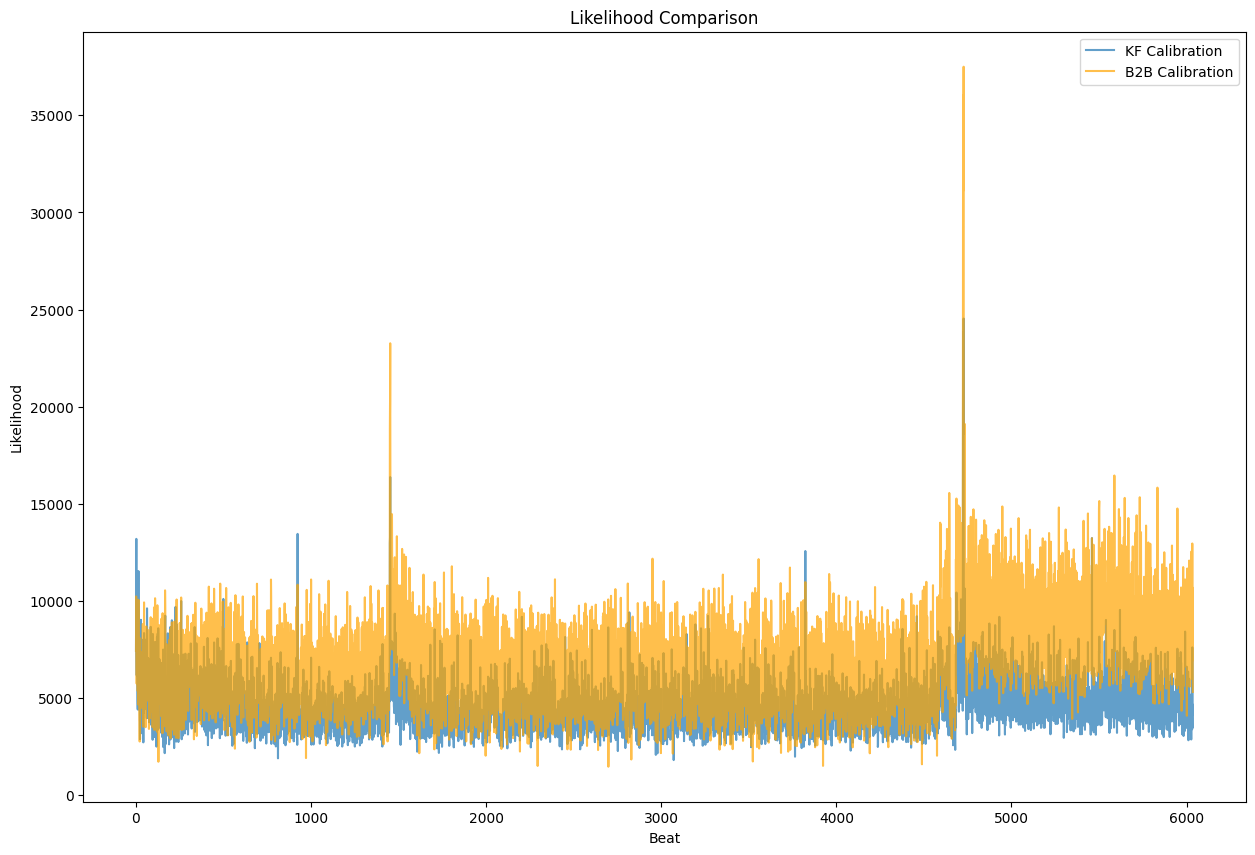

In [9]:
# compute likelihood for each output key for each row
likelihoods_kf= []
for row in range(len(prediction_error_kf_df)):
    likelihood_row = 0
    for i, key in enumerate(all_output_keys):
        error = error_values[i]
        residuals = prediction_error_kf_df.loc[row, key]
        likelihood_row += np.sum((residuals ** 2) / error ) 
    likelihoods_kf.append(likelihood_row)  

likelihoods_b2b= []
for row in range(len(prediction_error_b2b_df)):
    likelihood_row = 0
    for i, key in enumerate(all_output_keys):
        error = error_values[i]
        residuals = prediction_error_b2b_df.loc[row, key]
        likelihood_row += np.sum((residuals ** 2) / error )
    likelihoods_b2b.append(likelihood_row)



# Plot likelihood through time for kf and b2b calibration
plt.figure(figsize=(15, 10))
plt.plot(likelihoods_kf, label='KF Calibration', alpha=0.7)
plt.plot(likelihoods_b2b, label='B2B Calibration', alpha=0.7, color='orange')
plt.xlabel('Beat')
plt.ylabel('Likelihood')
plt.title('Likelihood Comparison')  
plt.legend()